# Using Text Data (Pet Descriptions)
Below, we run a Text Only model as well as a Text model unioned with our numerical model.

In [1]:
# Change this depending on where notebook is running
import os
os.chdir('..')

data_loc = "data/"

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

import data
from model import *

Using TensorFlow backend.


In [3]:
# Define data locations
train_images = data_loc + "train_images/*"
test_images = data_loc + "test_images/*"

breed_labels_file = data_loc + "breed_labels.csv"
state_labels_file = data_loc + "state_labels.csv"
color_labels_file = data_loc + "color_labels.csv"

train_file = data_loc + "train/train.csv"
test_file = data_loc + "test/test.csv"

train_sentiment_location = data_loc + "train_sentiment"
test_sentiment_location = data_loc + "test_sentiment"

In [4]:
breed_labels = pd.read_csv(breed_labels_file)
state_labels = pd.read_csv(state_labels_file)
color_labels = pd.read_csv(color_labels_file)
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

### Text Parsing

#### Process sentiment metadata
If the data has already been pre-processed, it will be read from disk.

In [5]:
preprocessed_file = "sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(train_df, train_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    train_df = train_df.merge(sentiment, on='PetID')

preprocessed_file = "test_sentiment_parsed.csv"
if len(glob(preprocessed_file)) == 0:
    data.get_sentiment(test_df, test_sentiment_location)
else:
    sentiment = pd.read_csv(preprocessed_file)
    test_df = test_df.merge(sentiment, on='PetID')

#### Parse Description

In [6]:
train_sequence, test_sequence, vocab_len = data.parse_description(train_df, test_df)

In [7]:
train_df['Sequence'] = train_sequence
test_df['Sequence'] = test_sequence

In [8]:
display(train_df[['Sequence']][:10])

,Sequence
0,"[11910, 19968, 19607, 896, 6971, 24660, 4220, ..."
1,"[20519, 7271, 12770, 4018, 4696, 8041, 3824, 1..."
2,"[18244, 4018, 22775, 8475, 19824, 16258, 5440,..."
3,"[8818, 2118, 13442, 13361, 7070, 18658, 8818, ..."
4,"[23514, 6971, 18598, 7844, 18482, 22686, 2501,..."
5,"[17019, 7071, 5472, 2793, 20768, 14745, 0, 0, ..."
6,"[15977, 9945, 17957, 22348, 18058, 18465, 1064..."
7,"[16258, 5440, 18482, 9945, 19798, 24976, 16401..."
8,"[11396, 13361, 5258, 7071, 20519, 2844, 13086,..."
9,"[22795, 6662, 17019, 20519, 18652, 19452, 1732..."


### Preprocess Numeric Data - One hot encoding

In [9]:
# One hot encode columns
for col, num_class in data.one_hot_cols.items():
    if col is not 'Breed1' and col is not 'Breed2':
        encode = data.one_hot_encode(train_df, col, num_class, inplace=True)
        encode = data.one_hot_encode(test_df, col, num_class, inplace=True)
        print("One hot encoding {} with {} classes...".format(col, num_class))

One hot encoding Type with 2 classes...
One hot encoding Gender with 3 classes...
One hot encoding Color1 with 7 classes...
One hot encoding Color2 with 7 classes...
One hot encoding Color3 with 7 classes...
One hot encoding MaturitySize with 5 classes...
One hot encoding FurLength with 4 classes...
One hot encoding Vaccinated with 3 classes...
One hot encoding Dewormed with 3 classes...
One hot encoding Sterilized with 3 classes...
One hot encoding Health with 4 classes...
One hot encoding State with 15 classes...


In [10]:
# One hot encode y-output
encode = data.one_hot_encode(train_df, 'AdoptionSpeed', inplace=True)

In [11]:
y_col = ['AdoptionSpeed_0', 'AdoptionSpeed_1', 'AdoptionSpeed_2', 'AdoptionSpeed_3', 'AdoptionSpeed_4']

In [12]:
numeric_cols = list(train_df.columns)
numeric_cols.remove("PetID") # String
numeric_cols.remove("Name") # String
numeric_cols.remove("RescuerID") # String
numeric_cols.remove("Description") # String, processed seperately
numeric_cols.remove("Sequence") # processed seperately

for col in y_col:
    numeric_cols.remove(col)

In [13]:
# Testing columns to remove
numeric_cols.remove('Breed1')
numeric_cols.remove('Breed2')

In [14]:
print(numeric_cols)

['Type', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore', 'NumSentences', 'Gender_1', 'Gender_2', 'Gender_3', 'Color1_1', 'Color1_2', 'Color1_3', 'Color1_4', 'Color1_5', 'Color1_6', 'Color1_7', 'Color2_0', 'Color2_2', 'Color2_3', 'Color2_4', 'Color2_5', 'Color2_6', 'Color2_7', 'Color3_0', 'Color3_3', 'Color3_4', 'Color3_5', 'Color3_6', 'Color3_7', 'MaturitySize_1', 'MaturitySize_2', 'MaturitySize_3', 'MaturitySize_4', 'FurLength_1', 'FurLength_2', 'FurLength_3', 'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health_1', 'Health_2', 'Health_3', 'State_41324', 'State_41325', 'State_41326', 'State_41327', 'State_41330', 'State_41332', 'State_41335', 'State_41336', 'State_41342', 'State_41345', 'State_41361', 'State_41367', 'State_41401', 'State_41415']


In [15]:
# Drop any nans
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [16]:
# normalize numeric columns
df = train_df[numeric_cols]
train_df[numeric_cols] = (df - df.min()) / (df.max() - df.min())

### Split into train and validation sets

In [17]:
text_cols = 'Sequence'

In [18]:
# Create a mask for training and validation data
msk = np.random.rand(len(train_df)) < 0.8

In [19]:
print("Let total:", len(train_df))
print("Len train:" , len(train_df[msk]))
print("Len valid:", len(train_df[~msk]))

Let total: 13215
Len train: 10607
Len valid: 2608


Split into training and validation data


In [20]:
# Text Data
train_x_text = train_df[text_cols][msk]
train_x_text = pd.DataFrame([row for row in train_x_text]) # To make this correct shape

valid_x_text = train_df[text_cols][~msk]
valid_x_text = pd.DataFrame([row for row in valid_x_text])

print("Train x shape {}".format(train_x_text.shape))
print("Valid x shape {}".format(valid_x_text.shape))

Train x shape (10607, 30)
Valid x shape (2608, 30)


In [21]:
# Numeric
train_x_num = train_df[numeric_cols][msk]
valid_x_num = train_df[numeric_cols][~msk]

print("Train x shape {}".format(train_x_num.shape))
print("Valid x shape {}".format(valid_x_num.shape))

Train x shape (10607, 65)
Valid x shape (2608, 65)


In [22]:
# The y's are the same for both text and numerical models
train_y = train_df[y_col][msk]
valid_y = valid_y_num = train_df[y_col][~msk]

## Text Only Model
Defined in model.py as TextOnlyModel

In [23]:
text_model = TextOnlyModel((train_x_text, train_y),
                           (valid_x_text, valid_y),
                           vocab_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
description_encoder (Sequent (None, 32)                829088    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 829,253
Trainable params: 829,253
Non-trainable params: 0
_________________________________________________________________


In [24]:
text_model.compile()
text_model.train(epochs=10)

Train on 10607 samples, validate on 2608 samples
Epoch 1/10
10607/10607 [==============================] - 53s 5ms/step - loss: 1.4785 - acc: 0.2734 - val_loss: 1.4634 - val_acc: 0.2910
Epoch 2/10
10607/10607 [==============================] - 40s 4ms/step - loss: 1.4394 - acc: 0.3304 - val_loss: 1.4284 - val_acc: 0.3543
Epoch 3/10
10607/10607 [==============================] - 40s 4ms/step - loss: 1.3486 - acc: 0.3897 - val_loss: 1.4416 - val_acc: 0.3386
Epoch 4/10
10607/10607 [==============================] - 40s 4ms/step - loss: 1.2582 - acc: 0.4377 - val_loss: 1.5264 - val_acc: 0.3259
Epoch 5/10
10607/10607 [==============================] - 42s 4ms/step - loss: 1.1837 - acc: 0.4784 - val_loss: 1.4693 - val_acc: 0.3493
Epoch 6/10
10607/10607 [==============================] - 41s 4ms/step - loss: 1.1187 - acc: 0.5219 - val_loss: 1.6145 - val_acc: 0.3160
Epoch 7/10
10607/10607 [==============================] - 40s 4ms/step - loss: 1.0569 - acc: 0.5649 - val_loss: 1.7189 - val_acc:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


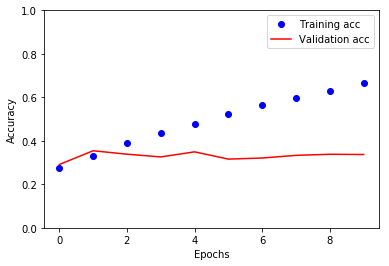

In [25]:
history = text_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [34]:
valid_pred = text_model.predict(valid_x_text)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.15723654981905455


## Numerical Model

In [35]:
class ImageFreeModel(KaggleModel):
    def __init__(self, train, test, shape):
        kernel = Sequential(name='image_free_encoder')
        
        kernel.add(BatchNormalization(input_shape=(shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Activation('relu'))
        
        kernel.add(Dense(64, activation='relu'))
        
        kernel.add(Dense(32, activation='relu'))

        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='image_free')
        model.add(kernel)
        
        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
numerical_model = ImageFreeModel((train_x_num, train_y),
                                 (valid_x_num, valid_y),
                                 train_x_num.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_free_encoder (Sequenti (None, 32)                19044     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 19,209
Trainable params: 19,079
Non-trainable params: 130
_________________________________________________________________


In [37]:
numerical_model.compile()
numerical_model.train(epochs=10)

Train on 10607 samples, validate on 2608 samples
Epoch 1/10
10607/10607 [==============================] - 5s 471us/step - loss: 1.4324 - acc: 0.3363 - val_loss: 1.3992 - val_acc: 0.3589
Epoch 2/10
10607/10607 [==============================] - 2s 183us/step - loss: 1.3815 - acc: 0.3764 - val_loss: 1.3938 - val_acc: 0.3581
Epoch 3/10
10607/10607 [==============================] - 2s 158us/step - loss: 1.3621 - acc: 0.3898 - val_loss: 1.3934 - val_acc: 0.3715
Epoch 4/10
10607/10607 [==============================] - 2s 166us/step - loss: 1.3414 - acc: 0.4012 - val_loss: 1.3999 - val_acc: 0.3646
Epoch 5/10
10607/10607 [==============================] - 2s 189us/step - loss: 1.3241 - acc: 0.4139 - val_loss: 1.4013 - val_acc: 0.3746
Epoch 6/10
10607/10607 [==============================] - 2s 166us/step - loss: 1.3071 - acc: 0.4222 - val_loss: 1.4215 - val_acc: 0.3689
Epoch 7/10
10607/10607 [==============================] - 2s 170us/step - loss: 1.2905 - acc: 0.4374 - val_loss: 1.4207 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


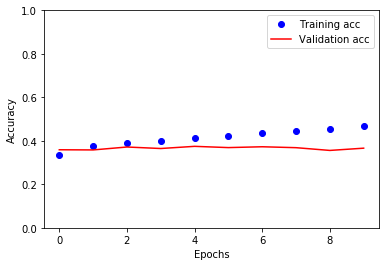

In [38]:
history = numerical_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [39]:
valid_pred = numerical_model.predict(valid_x_num)
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.24183437327596002


## Union Model
Combining ImageFreeModel with TextOnlyModel using UnionModel

In [40]:
class UnionModel2(KaggleModel):
    def __init__(self, models, train, test, freeze=True):
        
        xs = []
        ys = []
        for model in models:
            model = model.model
            x = Input(shape=model.input_shape[1:], name='{}_in'.format(model.name))
            
            # Get the first layer of the model. This is the encoder
            layer = model.get_layer(index=0)
            
            # It must not be trainable
            if freeze: layer.trainable = False
            # The output only utilizes the encoder component
            y = layer(x)
            
            # Output should be flat
            if len(y.shape) > 2:
                y = Flatten()(y)
                
            # Save values
            xs.append(x)
            ys.append(y)

        y = Concatenate()(ys)

        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = Dense(128)(y)
        y = BatchNormalization()(y)

        y = Dense(5, activation='softmax')(y)
        
        model = Model(xs, y)

        super().__init__(model, train, test)

    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
union_model = UnionModel2([text_model, numerical_model],
                         ([train_x_text, train_x_num], train_y),
                         ([valid_x_text, valid_x_num], valid_y))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_in (InputLayer)     (None, 30)           0                                            
__________________________________________________________________________________________________
image_free_in (InputLayer)      (None, 65)           0                                            
__________________________________________________________________________________________________
description_encoder (Sequential (None, 32)           829088      description_in[0][0]             
__________________________________________________________________________________________________
image_free_encoder (Sequential) (None, 32)           19044       image_free_in[0][0]              
__________________________________________________________________________________________________
concatenat

In [42]:
union_model.compile()
union_model.train(epochs=10)

Train on 10607 samples, validate on 2608 samples
Epoch 1/10
10607/10607 [==============================] - 14s 1ms/step - loss: 0.7496 - acc: 0.7306 - val_loss: 2.0914 - val_acc: 0.3566
Epoch 2/10
10607/10607 [==============================] - 8s 711us/step - loss: 0.7077 - acc: 0.7380 - val_loss: 2.1001 - val_acc: 0.3539
Epoch 3/10
10607/10607 [==============================] - 8s 737us/step - loss: 0.6889 - acc: 0.7464 - val_loss: 2.1772 - val_acc: 0.3528
Epoch 4/10
10607/10607 [==============================] - 7s 669us/step - loss: 0.6875 - acc: 0.7444 - val_loss: 2.1415 - val_acc: 0.3574
Epoch 5/10
10607/10607 [==============================] - 7s 652us/step - loss: 0.6839 - acc: 0.7487 - val_loss: 2.1879 - val_acc: 0.3577
Epoch 6/10
10607/10607 [==============================] - 7s 658us/step - loss: 0.6800 - acc: 0.7466 - val_loss: 2.1792 - val_acc: 0.3558
Epoch 7/10
10607/10607 [==============================] - 7s 678us/step - loss: 0.6805 - acc: 0.7469 - val_loss: 2.1297 - va

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


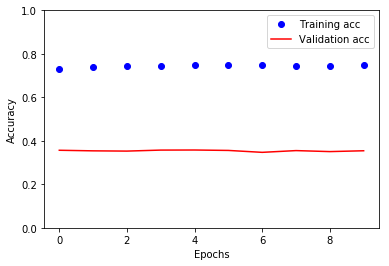

In [43]:
history = union_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [44]:
valid_pred = union_model.predict([valid_x_text, valid_x_num])
valid_pred = np.argmax(valid_pred, -1)
y_comp = np.argmax(np.array(valid_y), -1)
valid_kappa = cohen_kappa_score(y_comp, valid_pred, weights='quadratic')
print("Validation kappa: {}".format(valid_kappa))

Validation kappa: 0.21644705781364004
